In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

# Question 1

Download daily stock prices for 3 stocks (e.g., Apple (AAPL), Google (GOOG), Facebook (FB)) for the last 10 years from AlphaVantage, Quandl, Yahoo, Google Finance or anywhere else


Refs:

https://www.alphavantage.co/documentation/

https://blog.quandl.com/api-for-stock-data

https://www.quora.com/What-are-some-good-APIs-to-get-real-time-stock-quotes

You can use close prices

In [2]:
from alpha_vantage.timeseries import TimeSeries
key = 'N56TNNAOLMOR4V2O'
ts = TimeSeries(key, output_format='pandas')
tickers = ['NVDA', 'ATVI', 'MSFT']
data = []
for ticker in tickers:
    d, _ = ts.get_daily(symbol=ticker, outputsize='full')
    data.append(d[:'2010-02-23']['4. close'])

In [3]:
df = pd.concat(data, axis=1)

In [4]:
df.columns = tickers

In [5]:
df

,NVDA,ATVI,MSFT
date,,,
2020-02-21,294.07,63.375,178.59
2020-02-20,308.70,64.000,184.42
2020-02-19,314.70,64.370,187.28
2020-02-18,296.57,63.740,187.23
2020-02-14,289.79,63.520,185.35
...,...,...,...
2010-03-01,16.85,10.940,29.02
2010-02-26,16.20,10.630,28.67
2010-02-25,16.40,10.720,28.60


/home/tigven/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


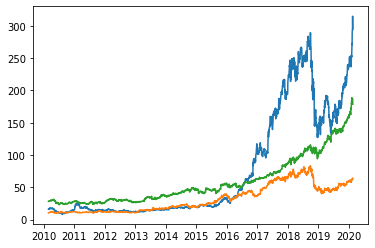

In [6]:
plt.plot(df)

# Question 2
Compute returns r_i = (P_{i+1} - P_{i}) / P_{i}, where i is today, and i + 1 is tomorrow

So r_i represents the return of an investment buying / selling today (day i) to selling / buying tomorrow (day i + 1).

Can you compute some statistics on the return time series?

For each stock

What is its distribution? Gaussian, Student-t with \nu degrees of freedom?

Is the distribution stationary over time?  (Hint: look for stationarity tests)

Is there any auto-correlation in the time series?

Is there any interesting relationships between the returns of different stocks at the same time (contemporaneous) and not? (Hint: look at correlation, Granger causality, PCA decomposition of returns)

In [7]:
r_i = df.rolling(2).apply(lambda x: (x[0] - x[1]) / x[1], raw=False).dropna()

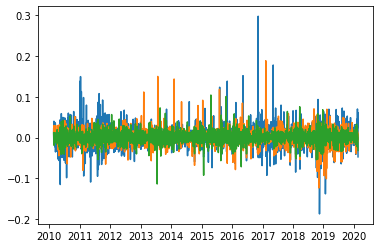

In [8]:
plt.plot(r_i)

## Some statistics

In [9]:
r_i.describe()

,NVDA,ATVI,MSFT
count,2516.000000,2516.000000,2516.000000
mean,0.001474,0.000890,0.000835
std,0.025504,0.018863,0.014355
min,-0.187559,-0.123905,-0.113995
25%,-0.010932,-0.009017,-0.006641
50%,0.001313,0.001048,0.000576
75%,0.013357,0.010592,0.008284
max,0.298067,0.188774,0.104522


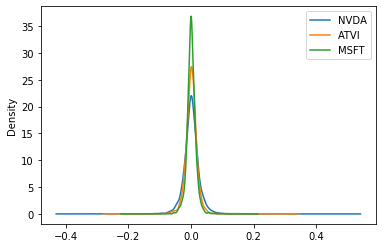

In [10]:
r_i.plot(kind='kde')

Looks like there is a normal distributon at every company's ROIs.
Let's check it by Kolmogorov-Smirnov test:

In [12]:
from sklearn import preprocessing
for ticker in tickers:
    norm_r_i = preprocessing.normalize([r_i[ticker]])
    t, p = stats.kstest(norm_r_i, 't', (0.001,))
    print('{} t distribution:\n t = {} \n p = {}'.format(ticker, t, p))
    t, p = stats.kstest(norm_r_i, 'norm')
    print('{} normal distribution:\n t = {} \n p = {}\n'.format(ticker, t, p))

NVDA t distribution:
 t = 0.5013446956030694 
 p = 0.9630786659240281
NVDA normal distribution:
 t = 0.5919862154161547 
 p = 0.8747126554057129

ATVI t distribution:
 t = 0.5012684243811284 
 p = 0.9631281681328923
ATVI normal distribution:
 t = 0.5789988809653567 
 p = 0.890809556650041

MSFT t distribution:
 t = 0.5011545752793226 
 p = 0.9632019811256337
MSFT normal distribution:
 t = 0.562803031978909 
 p = 0.9093855139982123



Probability of Student-t distribution with df = 0.001 is higher then Gussian distribution

### Check stationarity of data:

In [13]:
from statsmodels.tsa.stattools import adfuller
def perform_ADF_test(X):
    ADF_test = adfuller(X)
    print('ADF Statistic: %f' % ADF_test[0])
    print('p-value: %f' % ADF_test[1])
    print('Critical Values:')
    for key, value in ADF_test[4].items():
        print('\t%s: %.3f' % (key, value))

for ticker in tickers:
    print(ticker)
    perform_ADF_test(r_i[ticker])
    print()

NVDA
ADF Statistic: -51.011262
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567

ATVI
ADF Statistic: -16.155125
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567

MSFT
ADF Statistic: -20.347846
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567



The P-Value from our ADF test is much smaller than our 5% significance level, therefore we can reject the Null hypothesis and instead accept the alternate hypothesis that stationarity exists.

In [14]:
from statsmodels.tsa.stattools import kpss
def perform_kpss_test(X):
    kpss_test = kpss(X)    
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('lags: %f' % kpss_test[2])
    print('Critical Values:')
    for key, value in kpss_test[3].items():
        print('\t%s: %.3f' % (key, value))

for ticker in tickers:
    print(ticker)
    perform_kpss_test(r_i[ticker])
    print()

NVDA
KPSS Statistic: 0.345511
p-value: 0.100000
lags: 27.000000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

ATVI
KPSS Statistic: 0.074391
p-value: 0.100000
lags: 27.000000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

MSFT
KPSS Statistic: 0.423950
p-value: 0.066832
lags: 27.000000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739



/home/tigven/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/home/tigven/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/home/tigven/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


For all the statistics of the test is lower than the critical values. These results lead us to accept the null hypothesis of stationarity.

### Check autocorrelation of data:

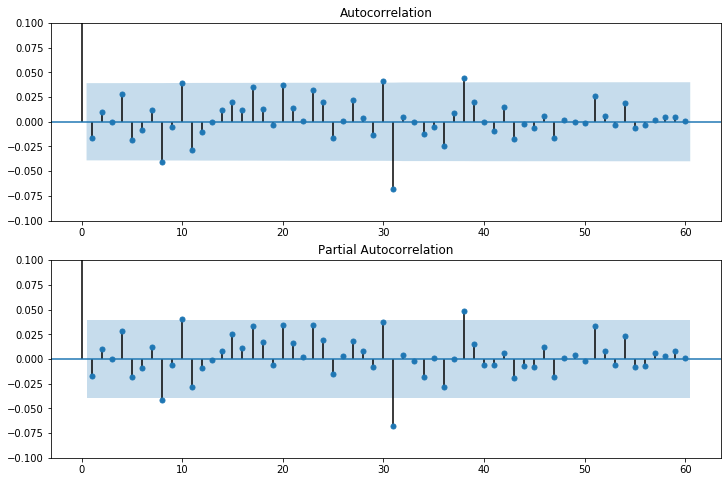

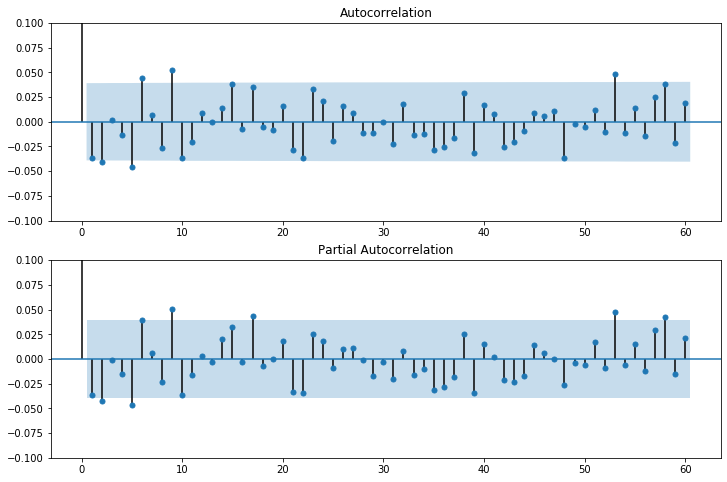

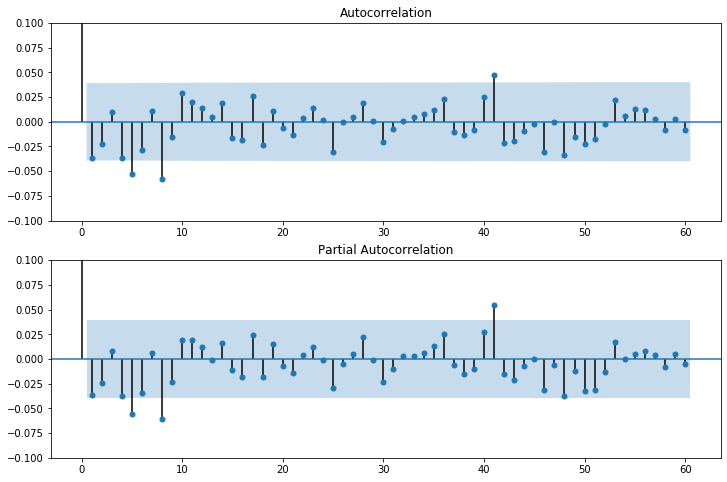

In [15]:
import statsmodels.api as sm
for ticker in tickers:
    fig = plt.figure(figsize=(12,8))
    
    ax1 = fig.add_subplot(211)
    plt.ylim(-0.1, 0.1)
    fig = sm.graphics.tsa.plot_acf(r_i[ticker].values.squeeze(), lags=60, ax=ax1)
    ax2 = fig.add_subplot(212)
    plt.ylim(-0.1, 0.1)
    fig = sm.graphics.tsa.plot_pacf(r_i[ticker], lags=60, ax=ax2)

In [16]:
from statsmodels.tsa.stattools import acf

for ticker in tickers:
    print(ticker)
    print(acf(r_i[ticker]))
    print()

NVDA
[ 1.00000000e+00 -1.68103141e-02  1.02164516e-02 -3.64803471e-04
  2.80667612e-02 -1.88427242e-02 -7.94562536e-03  1.16396544e-02
 -4.09775380e-02 -5.25499937e-03  3.96206521e-02 -2.83719871e-02
 -1.03652136e-02 -6.98263095e-04  1.15203979e-02  2.03517574e-02
  1.17727970e-02  3.53578085e-02  1.24422115e-02 -3.45986048e-03
  3.68172777e-02  1.41199373e-02  1.05938253e-03  3.16318062e-02
  2.02707394e-02 -1.67050589e-02  6.72566642e-04  2.18353843e-02
  3.91457336e-03 -1.29090841e-02  4.10108973e-02 -6.82391425e-02
  4.46943067e-03 -4.89564425e-04 -1.27696670e-02 -5.14646508e-03
 -2.46453136e-02  9.09809995e-03  4.38603138e-02  2.02900181e-02
 -3.09870251e-04]

ATVI
[ 1.00000000e+00 -3.68291754e-02 -4.07620813e-02  1.82860716e-03
 -1.33853780e-02 -4.54153649e-02  4.41517888e-02  6.60250406e-03
 -2.63441540e-02  5.20985975e-02 -3.67985271e-02 -2.09795172e-02
  8.55897915e-03 -2.73042339e-04  1.40823829e-02  3.79935439e-02
 -7.51593147e-03  3.51190718e-02 -5.13016372e-03 -8.03286305e

/home/tigven/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


I need to study theory of autocorrelation, but as I understand it now autocorrelation of our data is pretty low.

### Is there any interesting relationships between the returns of different stocks at the same time (contemporaneous) and not? (Hint: look at correlation, Granger causality, PCA decomposition of returns)

In [17]:
r_i.corr(method="spearman")

,NVDA,ATVI,MSFT
NVDA,1.000000,0.413710,0.468979
ATVI,0.413710,1.000000,0.457229
MSFT,0.468979,0.457229,1.000000


Correlation between all 3 companies is significant.

In [30]:
from statsmodels.tsa.stattools import grangercausalitytests
from itertools import permutations
for t1, t2 in permutations(tickers, 2):
    print('\n\n{} caused {}:'.format(t2, t1))
    grangercausalitytests(pd.concat((r_i[t1], r_i[t2]), axis=1), maxlag=5)



ATVI caused NVDA:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0003  , p=0.9860  , df_denom=2512, df_num=1
ssr based chi2 test:   chi2=0.0003  , p=0.9860  , df=1
likelihood ratio test: chi2=0.0003  , p=0.9860  , df=1
parameter F test:         F=0.0003  , p=0.9860  , df_denom=2512, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5148  , p=0.5977  , df_denom=2509, df_num=2
ssr based chi2 test:   chi2=1.0316  , p=0.5970  , df=2
likelihood ratio test: chi2=1.0314  , p=0.5971  , df=2
parameter F test:         F=0.5148  , p=0.5977  , df_denom=2509, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5095  , p=0.6758  , df_denom=2506, df_num=3
ssr based chi2 test:   chi2=1.5327  , p=0.6748  , df=3
likelihood ratio test: chi2=1.5322  , p=0.6749  , df=3
parameter F test:         F=0.5095  , p=0.6758  , df_denom=2506, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:     

The Null hypothesis for grangercausalitytests is that the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1. Grange causality means that past values of x2 have a statistically significant effect on the current value of x1, taking past values of x1 into account as regressors. We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below a desired size of the test.

I'll take target level 5%:
ATVI caused NVDA: True with all lags
MSFT caused NVDA: True with all lags
NVDA caused ATVI: True with lag=1
MSFT caused ATVI: True with all lags
NVDA caused MSFT: False with all lags
ATVI caused MSFT: True with lag=1

Looks like NVDA follows ATVI and MSFT, and ATVI follows MSFT.

# Question 3
Assume you have an equity strategy that every day makes a prediction f_i on the value of r_i

The profit-and-loss (PNL) for each day is: pnl_i = f_i * r_i

Assume that f_i is standard Gaussian with mean = 0 and std dev = 1

Generate a few random realizations of f_i: plot pnl_i and pnl = cumsum(pnl_i)

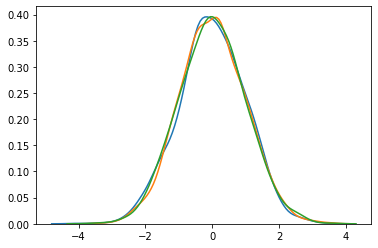

In [84]:
import seaborn as sns
mu, sigma = 0, 1
f = [np.random.normal(mu, sigma, 2516) for i in range(3)]
for f_i in f:
    sns.kdeplot(f_i)

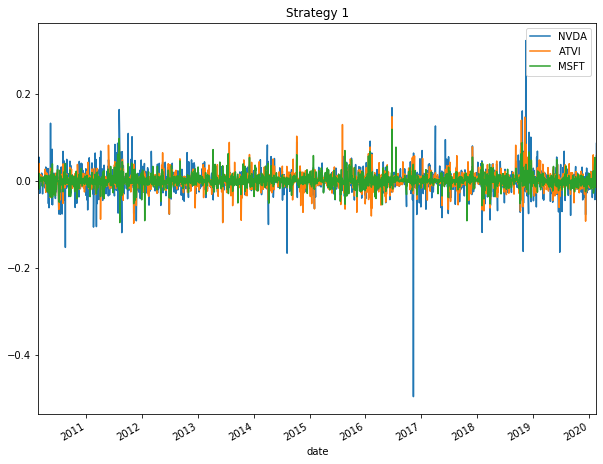

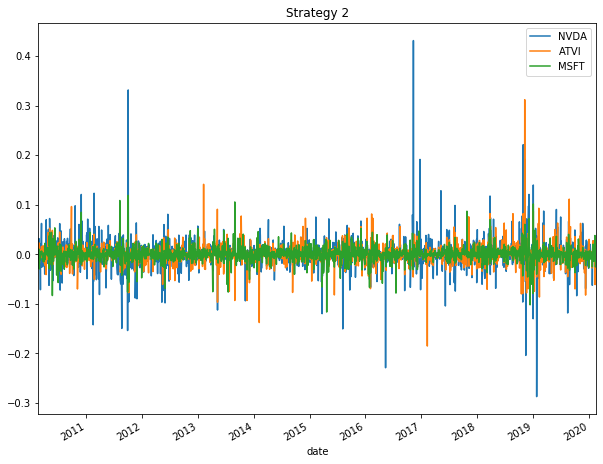

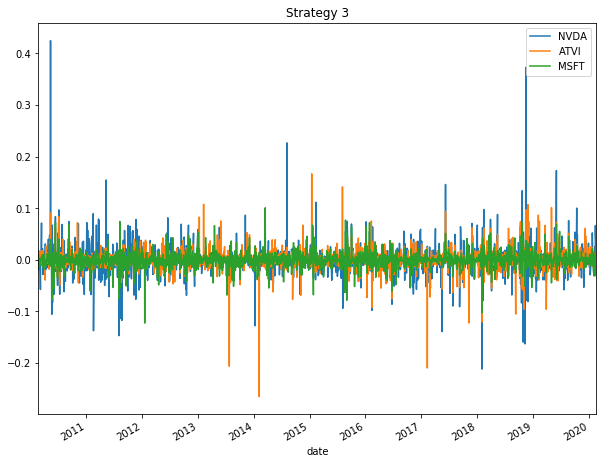

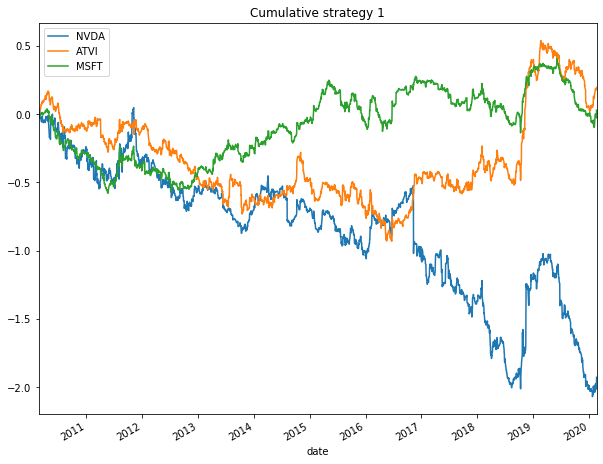

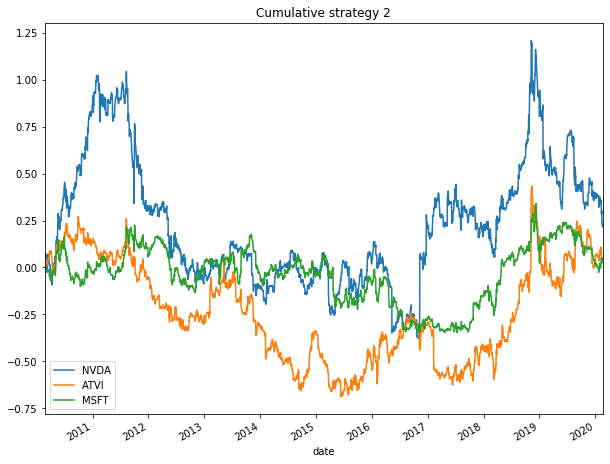

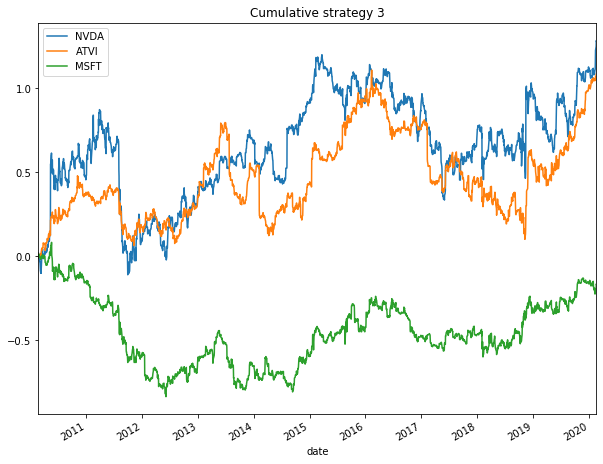

In [127]:
pnls = []
for i, f_i in enumerate(f, 1):
    
    pnl = r_i * ([f_i]*3)
    pnls.append(pnl)
    pnl.plot(figsize=(10,8), title='Strategy {}'.format(i))

for i, pnl in enumerate(pnls, 1):
    np.cumsum(pnl[::-1]).plot(figsize=(10,8), title='Cumulative strategy {}'.format(i))

# Question 4
For a PNL timeseries the Sharpe Ratio is defined as SR = E[pnl_i] / \sqrt{Var[pnl_i]}

Assume that f_i has a given hit rate = 1/n \sum_i (sign(f_i) == sign(r_i))

Hit rate is a measure of accuracy: how often we guess the direction of the stock movement correctly

Remember that f_i is a random variable so you can draw different realizations of it

What is the distribution of the SR(pnl_i) given f_i?

Ideally, you want to generate a plot varying hit_rate from 0 to 1.0 on the x-axis and computing the corresponding distribution of SR on the y-axis

Note that pnl_i is a random var since it is a function of the random variable f_i

You can plot the distribution as a box plot or using just mean and std err

In [144]:
SRs = []
for pnl in pnls:
    SR = pnl.mean() / pnl.std()
    SRs.append(SR)
print(SRs)

[NVDA   -0.029709
ATVI    0.004427
MSFT    0.000870
dtype: float64, NVDA    0.003272
ATVI    0.000898
MSFT    0.000892
dtype: float64, NVDA    0.019187
ATVI    0.022497
MSFT   -0.004837
dtype: float64]


Check hit rate of strategies:

In [143]:
for i, f_i in enumerate(f, 1):
    print('Hit rates of strategie №', i)
    print((np.sign([f_i]*3).T == np.sign(r_i)).mean())
    print()

Hit rates of strategie № 1
NVDA    0.484897
ATVI    0.484499
MSFT    0.481717
dtype: float64

Hit rates of strategie № 2
NVDA    0.493641
ATVI    0.498410
MSFT    0.496025
dtype: float64

Hit rates of strategie № 3
NVDA    0.497218
ATVI    0.502385
MSFT    0.494833
dtype: float64



In [211]:
import random
def generate_strategies(data, hitrates=[1]):
    """Generate random strategie with given hitrate"""
    basic_strategie = np.absolute(np.random.normal(0, 1, data.size)) * np.sign(data)
    basic_strategies = np.asarray([basic_strategie] * len(hitrates))
    for j, hitrate in enumerate(hitrates):
        inverted_number = round(data.size * (1 - hitrate))
        ind_to_invert = random.sample(range(data.size), int(inverted_number))
        for i in ind_to_invert:
            basic_strategies[j][i] *= -1
    return basic_strategies

In [239]:
hitrates = np.linspace(0, 1, 11)
pnls = defaultdict(list)
for ticker in tickers:
    for i in range(1000):
        strtgs = generate_strategies(r_i[ticker], hitrates)
        pnls[ticker].append(np.asarray([r_i[ticker]]*11) * strtgs.T)
    pnls[ticker] = np.asarray(pnls[ticker])

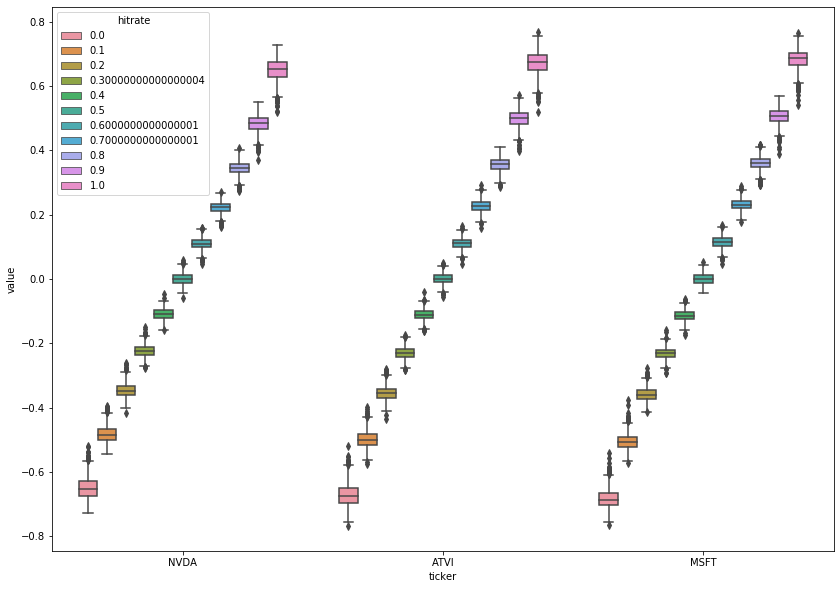

In [297]:
df = {}
for name, pnl in pnls.items():
    pnl = np.swapaxes(pnl, 0, 1)
    SR = pnl.mean(axis=2)/pnl.std(axis=2)
    df[name] = pd.DataFrame(SR.T, columns=hitrates).assign(ticker=name)

fig, ax = plt.subplots(figsize=(14,10))
cdf = pd.concat([df[ticker] for ticker in tickers])
mdf = pd.melt(cdf, id_vars=['ticker'], var_name=['hitrate'])
ax = sns.boxplot(x='ticker', y='value', hue='hitrate', data=mdf, ax=ax)
plt.show()

# Question 5
What if, instead of hit rate, you use root mean square error (RMSE) between f_i and r_i?

How does the distribution of SR change?

What if you use mean absolute deviation (MAD) of f_i and r_i?

Make the code flexible to changing input measures (hit rate, RMSE, MAD) and output measures

In [305]:
def generate_strategies(data, rmse=None, hitrate=None, mad=None):
    """Generate random strategie with given measure"""
    if rmse is not None:
        pass
    elif hitrate is not None:
        pass
    elif mad is not None:
        return data + mad * random.choice([-1,1])
    else:
        raise Exception('Set one of input measures: rmse, hitrate, mad')
    return 